## Neural Network

In [121]:
import torch
import torchmetrics
from torch import nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import  classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Loading pre processed datas
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')
weights = np.load('Pre_Processed_Data\class_weights.npy', allow_pickle=True).item()

# Value to distinguish if an istance belongs to class 0 or class 1 
round_treshold = 0.50

# Let's convert data to PyTorch tensors

In [122]:
# Convert the class weight dictionary to a PyTorch tensor of type Float
weights_tensor = torch.tensor([weights[i] for i in range(len(weights))]).float()

X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).long()
X_val = torch.tensor(val_features).float()
y_val = torch.tensor(val_labels).long()
X_test = torch.tensor(test_features).float()
y_test = torch.tensor(test_labels).long()

# Creating DataLoaders for the training and validation set

In [123]:
batch_size = 10
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Defining neural network architecture

In [124]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        x = torch.sigmoid(x)
        return x


# Creating an instance of the model

In [125]:
model = Net()

# Let's define the loss function and the optimizer

In [126]:
# I define the loss function and optimizer with class weights
# I create an instance of the CrossEntropyLoss policy using class weights
criterion_class0 = nn.BCELoss(weight=weights_tensor[0])
criterion_class1 = nn.BCELoss(weight=weights_tensor[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Defining the function to validate the model on the validation set

In [127]:
def validate_model(model, validation_loader):
    model.eval()
    f1 = torchmetrics.classification.BinaryF1Score()
    with torch.no_grad():
        for features, labels in validation_loader:
            outputs = model(features)
            preds = (outputs > round_treshold).float()
            new_labels = labels.unsqueeze(1)
            new_labels = new_labels.float()
            for j in range (len(new_labels)-1):
                f1.update(preds,new_labels)
    f1_output = f1.compute()
    return f1_output

# I define the variables for early stopping

In [128]:
# early stopping variables definitions
best_f1_validation = 0  # Initial value for comparison
patience = 300  # Number of epochs to tolerate the decrease in accuracy on the validation set
delta_threshold = 0.001 # Improvement threshold based on accuracy on the validation set
counter = 0  # Counter for the number of epochs without improvement.

# Training the model

In [129]:
num_epochs=1000

for epoch in range(num_epochs):
    
    model.train() 
    epoch_loss_sum = 0.0 
    for (features,labels) in (train_loader):

        optimizer.zero_grad() 
        outputs=model(features)
        new_labels = labels.unsqueeze(1)
        new_labels = new_labels.float()
   
        for j in range (len(new_labels)-1):
            if new_labels[j] == 0:
                loss = criterion_class0(outputs[j][0],new_labels[j][0])
            else:
                loss = criterion_class1(outputs[j][0],new_labels[j][0])
      
        
        epoch_loss_sum+=loss.item() 
        loss.backward() 
        optimizer.step() 
        loss=0

    epoch_loss_avg=epoch_loss_sum/len(train_loader) 
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}')
    
    # Verifico se l'accuratezza corrente sul set di validazione è migliore dell'accuratezza migliore finora
    f1_validation = validate_model(model,val_loader)
    if f1_validation.item() - best_f1_validation > delta_threshold:
        print(f1_validation.item())
        best_f1_validation = f1_validation.item() 
        counter=0 
        torch.save(model.state_dict(),'best_model.pth') 
    else: 
        counter+=1 

    # Stampo l'accuratezza sul set di validazione ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Accuracy on validation set: {f1_validation:.4f}')

    if counter>=patience:
        print(f'Stopping early at epoch {epoch + 1}')
        break

Epoch [1/1000], Loss: 0.7157
0.5303612351417542
Epoch [2/1000], Loss: 0.6736
Epoch [3/1000], Loss: 0.7060
Epoch [4/1000], Loss: 0.7174
Epoch [5/1000], Loss: 0.7395
Epoch [6/1000], Loss: 0.7061
0.568837583065033
Epoch [7/1000], Loss: 0.6736
Epoch [8/1000], Loss: 0.7217
Epoch [9/1000], Loss: 0.7262
Epoch [10/1000], Loss: 0.7648
Epoch [10/1000], Accuracy on validation set: 0.5304
Epoch [11/1000], Loss: 0.7033
Epoch [12/1000], Loss: 0.6847
Epoch [13/1000], Loss: 0.7417
Epoch [14/1000], Loss: 0.7248
Epoch [15/1000], Loss: 0.6529
Epoch [16/1000], Loss: 0.7850
0.6336088180541992
Epoch [17/1000], Loss: 0.7243
Epoch [18/1000], Loss: 0.7258
Epoch [19/1000], Loss: 0.7429
Epoch [20/1000], Loss: 0.6575
Epoch [20/1000], Accuracy on validation set: 0.5304
Epoch [21/1000], Loss: 0.7009
0.7450110912322998
Epoch [22/1000], Loss: 0.7215
Epoch [23/1000], Loss: 0.7612
Epoch [24/1000], Loss: 0.7411
Epoch [25/1000], Loss: 0.6724
Epoch [26/1000], Loss: 0.6430
Epoch [27/1000], Loss: 0.6387
Epoch [28/1000], Los

# Carica il miglior modello

In [130]:
# Loading the best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

# Evaluating the model on test set

In [131]:
from sklearn.metrics import precision_score
precision = torchmetrics.Precision(num_classes=2, task='binary')
correct = 0
total = 0
precision_values = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        new_labels = labels.unsqueeze(1)
        new_labels = new_labels.float()
   
        for j in range (len(new_labels)-1):
            precision.update(preds,new_labels)
precision = precision.compute()
print(f'Precision on test set: {precision:.4f}')

Precision on test set: 0.5600


# Confusion Matrix

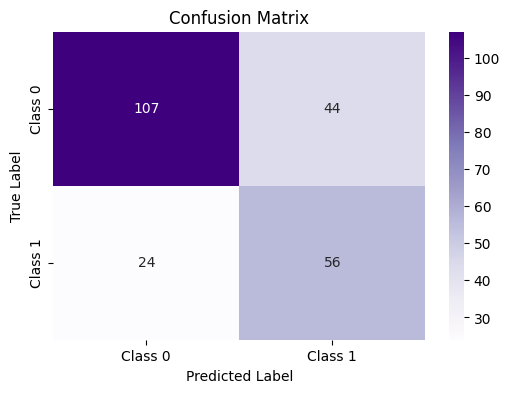

In [132]:
# Compute confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
cm = confusion_matrix(y_true, y_pred)
# Define class labels
class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report

In [133]:
model.eval()
test_predictions = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        test_predictions.extend(preds.tolist())

# Calcolo il report di classificazione
report = classification_report(test_labels.tolist(), test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76       151
           1       0.56      0.70      0.62        80

    accuracy                           0.71       231
   macro avg       0.69      0.70      0.69       231
weighted avg       0.73      0.71      0.71       231



# ROC and AUC

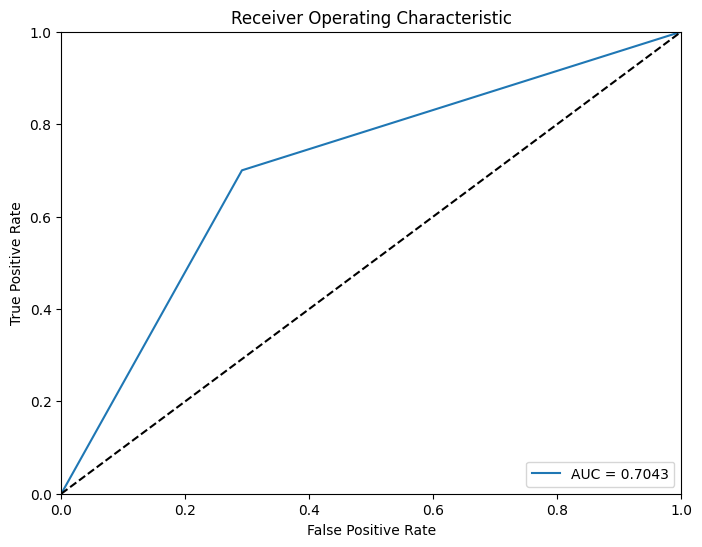

AUC: 0.7043046357615894


In [134]:
model.eval()
test_probabilities = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = (outputs > round_treshold).float()
        test_probabilities.extend(preds.tolist())

# Calcolo la curva ROC e l'AUC
fpr, tpr, thresholds = roc_curve(test_labels.tolist(), test_probabilities)
auc = roc_auc_score(test_labels.tolist(), test_probabilities)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("AUC:", auc)